# 讀取 Packages

In [1]:
!pip install pmdarima
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from matplotlib.pyplot import figure
from patsy import dmatrix

from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima import ARIMA
from pmdarima.arima import AutoARIMA

from IPython.display import Image

warnings.filterwarnings("ignore")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 19.0 MB/s eta 0:00:00


# 讀取數據

In [2]:
data = pd.read_csv('/kaggle/input/bike-rent/tmp_bike_hour.csv')
data.head(10)

hour  count
0  2017-01-01 00:00:00    457
1  2017-01-01 01:00:00    337
2  2017-01-01 02:00:00    185
3  2017-01-01 03:00:00    144
4  2017-01-01 04:00:00    117
5  2017-01-01 05:00:00    130
6  2017-01-01 06:00:00    205
7  2017-01-01 07:00:00    240
8  2017-01-01 08:00:00    371
9  2017-01-01 09:00:00    398

* 變數為計數型資料
* 將變數進行對數轉換後再配適模型 ( 可讓預測結果大於 0 )

In [3]:
# 將計數變數取對數
data['count_log'] = np.log(data["count"] + 1)
data.head(5)

hour  count  count_log
0  2017-01-01 00:00:00    457   6.126869
1  2017-01-01 01:00:00    337   5.823046
2  2017-01-01 02:00:00    185   5.225747
3  2017-01-01 03:00:00    144   4.976734
4  2017-01-01 04:00:00    117   4.770685

In [4]:
n = data.shape[0]
y = data["count_log"]

# 建立時間序列模型

## 深度學習模型
* 建立深度學習模型需先整理資料成函數可讀入的形式
* 以下圖進行整理

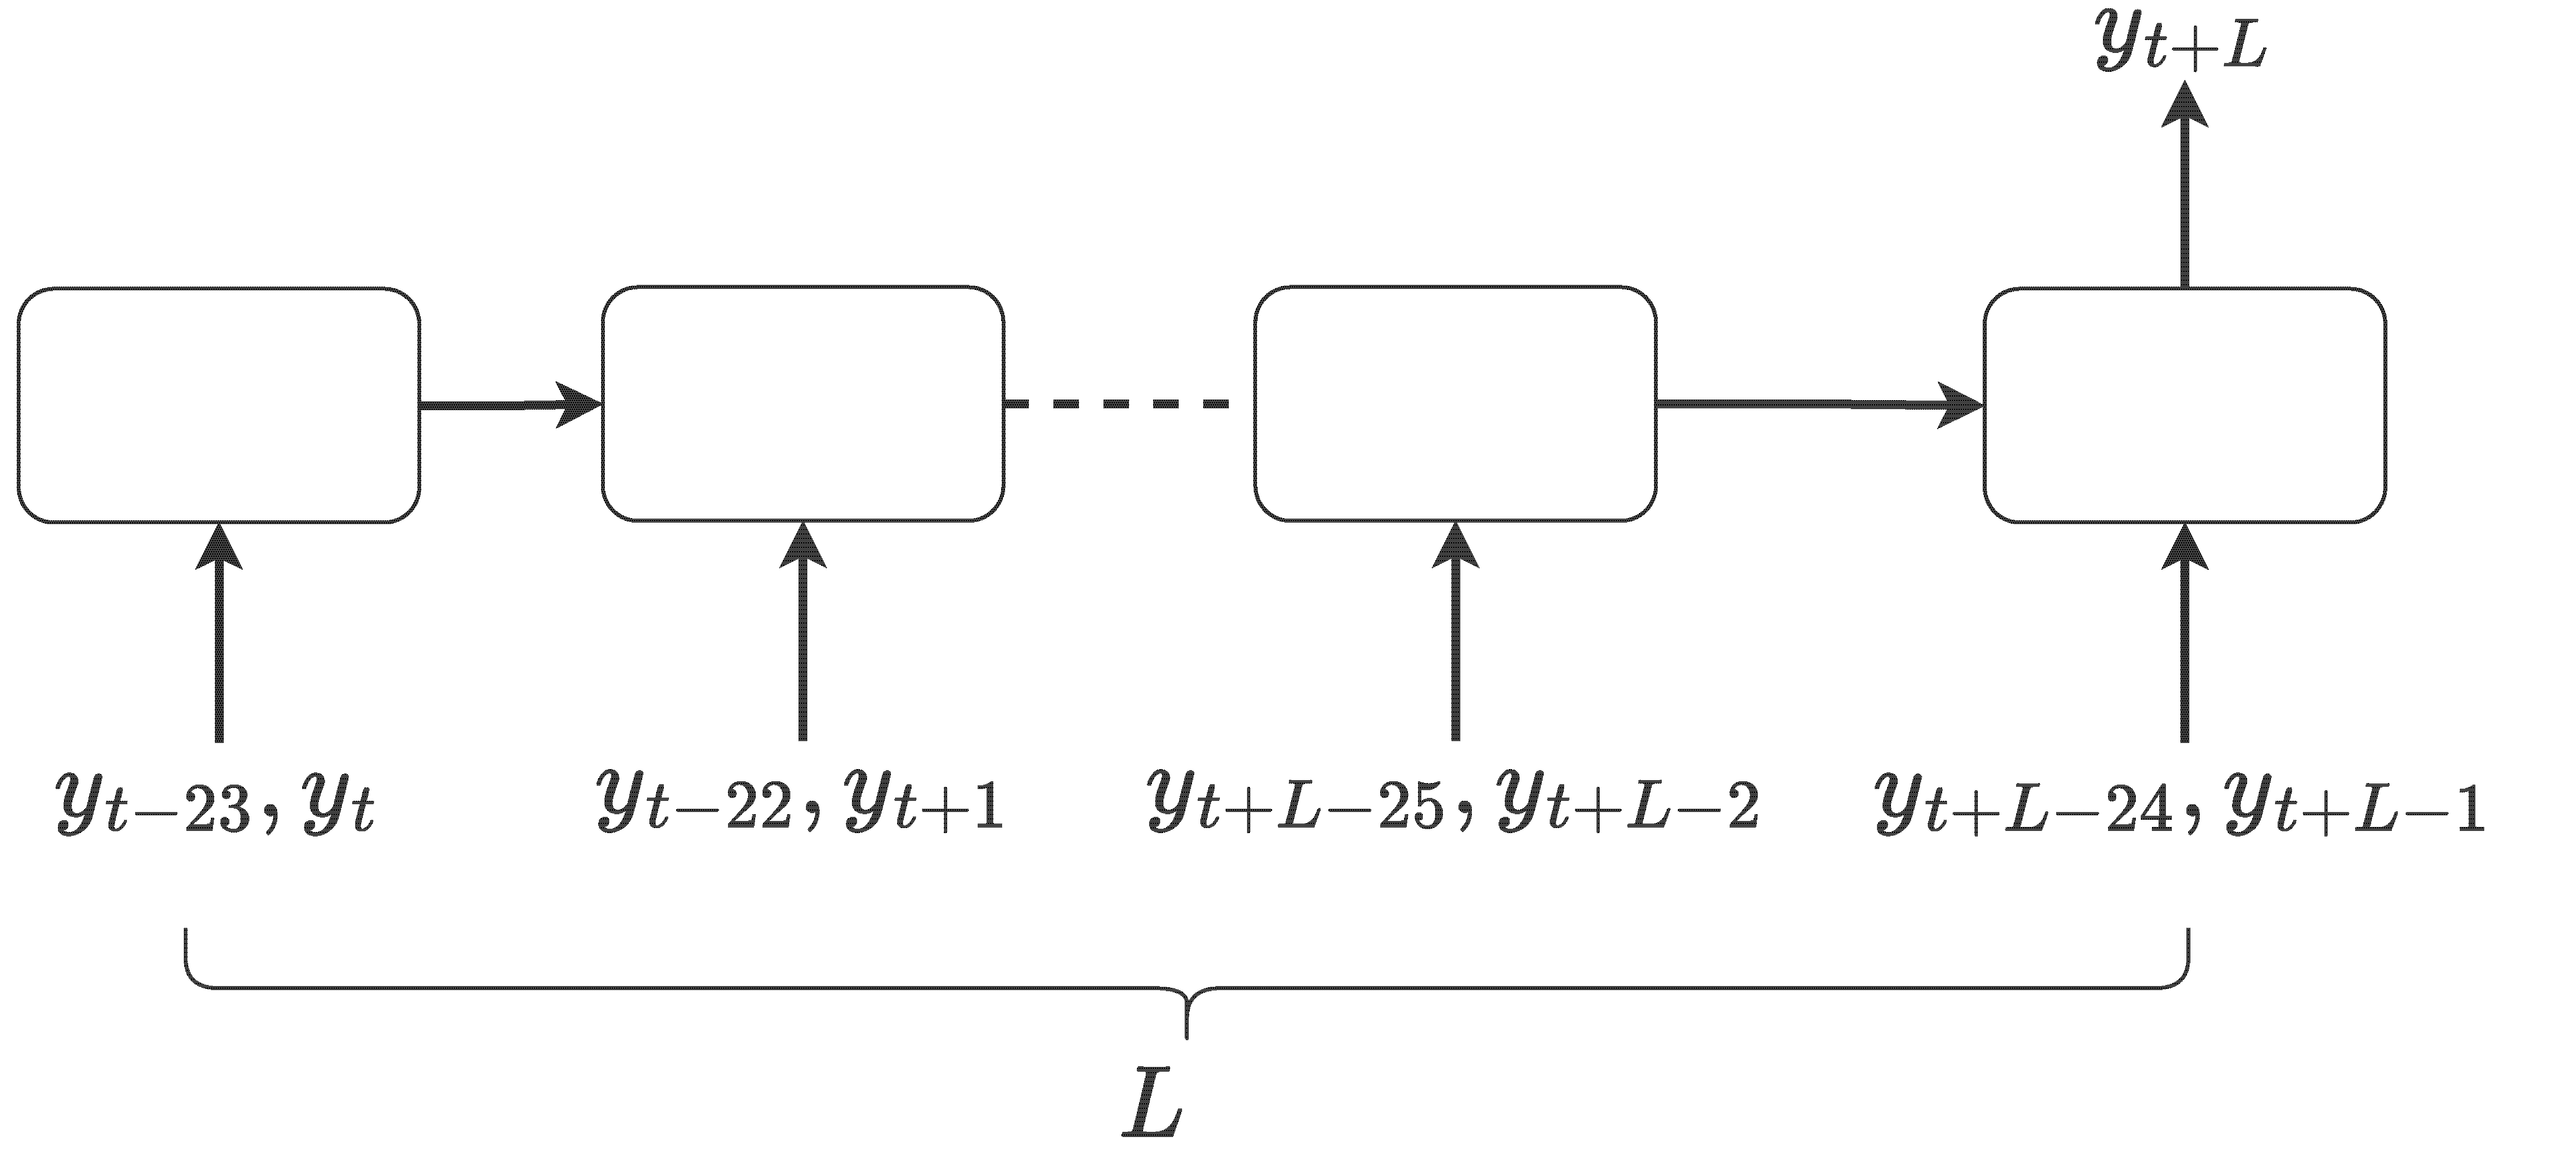

In [5]:
Image('/kaggle/input/bike-rent/Data_create.png',width=800)

In [6]:
time_len = 24
# 資料集個數,設定模型長度,變數個數
new_X =  np.ones((n-24-time_len,time_len,2))
new_n = n-24-time_len
for i in range(24,n-time_len):
    new_X[i-24,:,0] = y[i:(i+time_len)]
    new_X[i-24,:,1] = y[(i-23):(i-24+time_len+1)]

In [7]:
train_n = int(new_n*0.6)
val_n = int(new_n*0.2)
test_n = new_n - train_n - val_n

# 訓練集
new_X_train = new_X[0:train_n,:,:]
y_train = y[(24+time_len):(train_n+24+time_len)]
# 驗證集
new_X_val = new_X[train_n:(train_n+val_n),:,:]
y_val = y[(train_n+24+time_len):(train_n+val_n+24+time_len)]
# 測試集
new_X_test =  new_X[(train_n+val_n):,:,:]
y_test = y[(train_n+val_n+24+time_len):]

In [8]:
# Import the Keras libraries and packages
from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.layers import SimpleRNN
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dense
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# 設定隱藏層的節點個數
tmp_hidden_size = 50

# 紀錄不同模型訓練時訓練集 MSE 的軌跡
train_RMSE_trace = dict()
# 紀錄不同模型訓練時驗證集 MSE 的軌跡
val_RMSE_trace = dict()
# 紀錄不同模型最後的測試集 MSE 
test_RMSE = dict()
# 紀錄不同模型最後的測試集 MSE ( 還原成原本租車人數 ) 
test_RMSE_org = dict()
# 紀錄不同模型最後的測試集的預測結果
test_predicts = dict()
# 設定亂數種子 ( 因模型訓練有隨機效應，可設定單一數值固定結果 )
tf.random.set_seed(20230404)


for tmp_model_str in ["SimpleRNN","LSTM","GRU"]:

    exec("tmp_model = %s" % tmp_model_str)
    # Initialising the RNN
    regressor = Sequential()
    # Adding the first LSTM layer and some Dropout regularisation
    regressor.add(tmp_model(units = tmp_hidden_size,  input_shape = (time_len, 2)))
    regressor.add(BatchNormalization())
    regressor.add(Dropout(0.1))
    regressor.add(Dense(1))

    # 設定 optimizer
    adam = Adam(lr = 0.005, beta_1= 0.9, beta_2 = 0.999, decay = 0.001)
    # 設定 loss
    regressor.compile(loss = 'mean_squared_error', optimizer = adam,
                      metrics = [tf.keras.metrics.RootMeanSquaredError()])

    # 設定 early stopping
    callback = EarlyStopping(monitor = 'loss', patience = 40, restore_best_weights = True)
    # 進行訓練
    history = regressor.fit(new_X_train, y_train, epochs = 200, batch_size = 32,
                  validation_data = (new_X_val,y_val),callbacks = [callback])
    
    # 儲存在訓練過程中訓練集的 RMSE
    train_RMSE_trace[tmp_model_str] = np.sqrt(history.history['loss'])
    # 儲存在訓練過程中驗證集的 RMSE
    val_RMSE_trace[tmp_model_str] = np.sqrt(history.history['val_loss'])

    # 儲存最後模型在測試集的預測值
    y_test_predict = regressor.predict(new_X_test).flatten()
    test_predicts[tmp_model_str] = y_test_predict
    # 儲存最後模型在測試集的 RMSE ( 取過對數後 ) 
    test_RMSE[tmp_model_str] = np.sqrt(np.mean((y_test_predict-y_test.values)**2))
    # 儲存最後模型在測試集的 RMSE ( 還原為原始搭乘人數 )
    test_RMSE_org[tmp_model_str] = np.sqrt(np.mean((np.exp(y_test_predict)-np.exp(y_test.values))**2))

Epoch 1/200
369/369 [==============================] - 8s 16ms/step - loss: 2.8995 - root_mean_squared_error: 1.7028 - val_loss: 1.2018 - val_root_mean_squared_error: 1.0963
Epoch 2/200
369/369 [==============================] - 5s 14ms/step - loss: 0.3151 - root_mean_squared_error: 0.5614 - val_loss: 0.2032 - val_root_mean_squared_error: 0.4508
Epoch 3/200
369/369 [==============================] - 5s 14ms/step - loss: 0.2919 - root_mean_squared_error: 0.5402 - val_loss: 0.2081 - val_root_mean_squared_error: 0.4561
Epoch 4/200
369/369 [==============================] - 6s 16ms/step - loss: 0.2806 - root_mean_squared_error: 0.5297 - val_loss: 0.2458 - val_root_mean_squared_error: 0.4958
Epoch 5/200
369/369 [==============================] - 5s 13ms/step - loss: 0.2731 - root_mean_squared_error: 0.5225 - val_loss: 0.2240 - val_root_mean_squared_error: 0.4733
Epoch 6/200
369/369 [==============================] - 5s 13ms/step - loss: 0.2587 - root_mean_squared_error: 0.5087 - val_loss: 0

畫出在訓練過程中驗證集的 RMSE

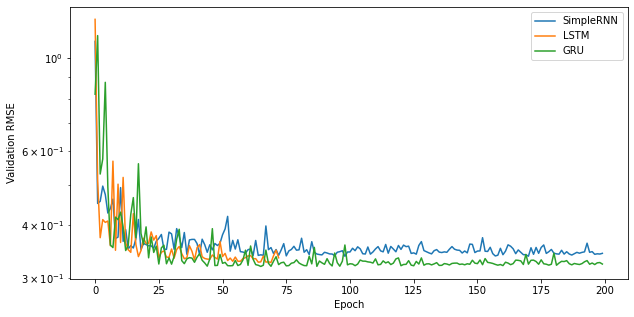

In [9]:
figure(figsize=(10, 5))
for tmp_model_str in ["SimpleRNN","LSTM","GRU"]:
    plt.plot(val_RMSE_trace[tmp_model_str],label = tmp_model_str)
    plt.legend(loc = "upper right")
    plt.yscale('log')
    plt.ylabel('Validation RMSE')
    plt.xlabel('Epoch')

## SARIMA 模型


ADF Statistic: -11.487892
p-value: 0.000000


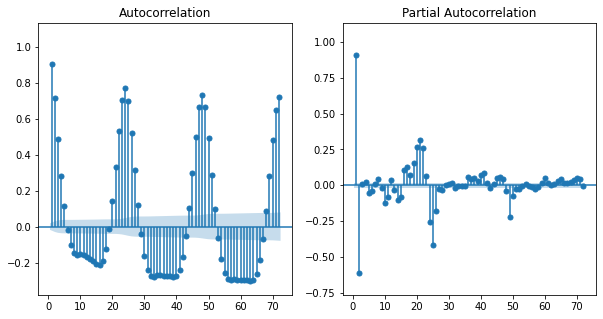

In [10]:
# 檢查時間序列是否平穩
result = adfuller(y_train.values)
print('ADF Statistic: %f' % result[0])
# p-value<0.05 拒絕他是非平穩序列 
print('p-value: %f' % result[1])

# 與輸出 acf 與 pacf 圖
# 發現有 24 為一期的週期效應
fig, ax = plt.subplots(1,2,figsize = (10,5))
plot_acf(y_train.values,lags = 72, zero = False,auto_ylims = True, ax = ax[0])
plot_pacf(y_train.values,lags = 72, zero = False,auto_ylims = True, ax = ax[1])
plt.show()

In [11]:
# 自動使用 AIC 選擇 ARIMA 模型的階次
#model = AutoARIMA(m =24, out_of_sample_size =n-(train_n+24+time_len), trace =True,
#                   n_jobs =-1,max_p =2,max_q =2,d  =0)
#model_fit = model.fit(y.values)

In [12]:
# out_of_sample_size: 告知沒有參與訓練的資料大小
model = ARIMA(order = (12,0,12),
              seasonal_order = (1,0,1,24), 
              out_of_sample_size = val_n+test_n)
model_fit = model.fit(y.values)
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                19680
Model:             SARIMAX(12, 0, 12)x(1, 0, [1], 24)   Log Likelihood               -4682.951
Date:                                Fri, 21 Apr 2023   AIC                           9421.902
Time:                                        22:08:20   BIC                           9642.748
Sample:                                             0   HQIC                          9494.213
                                              - 19680                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0061      0.001      5.228      0.000       0.004       0.008
ar.L1         -1.0459      0.061    -17.025      0.000      -1.166      -0.925
ar.L2         -0.2739      0.015    -18.866      0.000      -0.302      -0.245
ar.L3         -0.2681      0.027     -9.875      0.000      -0.321      -0.215
ar.L4         -0.4080      0.025    -16.576      0.000      -0.456      -0.360
ar.L5          0.1911      0.024      8.108      0.000       0.145       0.237
ar.L6          0.9231      0.043     21.630      0.000       0.839       1.007
ar.L7          0.7830      0.047     16.624      0.000       0.691       0.875
ar.L8          0.3129      0.023     13.754      0.000       0.268       0.358
ar.L9          0.4607      0.017     27.700      0.000       0.428       0.493
ar.L10         0.4409      0.022     20.490      0.000       0.399       0.483
ar.L11        -0.4494      0.021    -21.199      0.000      -0.491      -0.408
ar.L12        -0.3481      0.055     -6.343      0.000      -0.456      -0.241
ma.L1          1.9817      0.061     32.270      0.000       1.861       2.102
ma.L2          2.0707      0.069     29.838      0.000       1.935       2.207
ma.L3          2.0745      0.051     41.058      0.000       1.975       2.174
ma.L4          2.2199      0.045     48.888      0.000       2.131       2.309
ma.L5          1.8274      0.042     43.908      0.000       1.746       1.909
ma.L6          0.7776      0.052     14.943      0.000       0.676       0.880
ma.L7         -0.0762      0.080     -0.955      0.340      -0.233       0.080
ma.L8         -0.3837      0.093     -4.121      0.000      -0.566      -0.201
ma.L9         -0.7354      0.088     -8.337      0.000      -0.908      -0.562
ma.L10        -1.0024      0.084    -11.874      0.000      -1.168      -0.837
ma.L11        -0.3938      0.057     -6.936      0.000      -0.505      -0.283
ma.L12         0.0068      0.007      1.014      0.310      -0.006       0.020
ar.S.L24       0.9984      0.000   4917.716      0.000       0.998       0.999
ma.S.L24      -0.9457      0.002   -385.271      0.000      -0.950      -0.941
sigma2         0.0938      0.000    313.242      0.000       0.093       0.094
===================================================================================
Ljung-Box (L1) (Q):                   0.18   Jarque-Bera (JB):           2034930.83
Prob(Q):                              0.67   Prob(JB):                         0.00
Heteroskedasticity (H):               0.81   Skew:                             0.33
Prob(H) (two-sided):                  0.00   Kurtosis:                        52.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

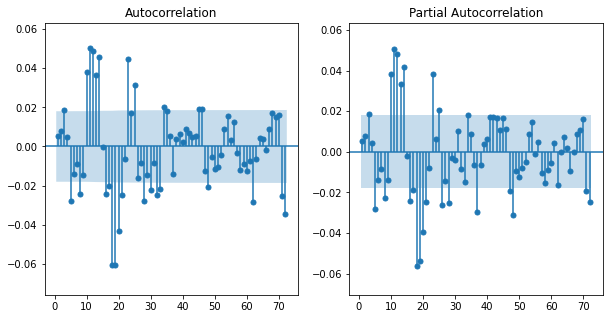

In [13]:
# 找出配適的 arima 的殘差
train_n_arima = n-(val_n+test_n)
y_train_predict = model_fit.predict_in_sample(start = 0, end = train_n_arima)
# 檢查殘差的 acf 和 pacf
fig, ax = plt.subplots(1,2,figsize = (10,5))
plot_acf(y[0:train_n_arima+1]-y_train_predict, lags = 72, zero = False, 
         auto_ylims = True, ax = ax[0])
plot_pacf(y[0:train_n_arima+1]-y_train_predict, lags = 72, zero = False, 
          auto_ylims = True, ax = ax[1]) 
plt.show()

In [14]:
# 輸出測試集的預測值
y_test_predict = model_fit.predict_in_sample(start = n-(test_n), end = n-1)
test_predicts["ARIMA"] = y_test_predict
# 儲存最後模型在測試集的 RMSE ( 取過對數後 ) 
test_RMSE["ARIMA"] = np.sqrt(np.mean((y_test_predict-y_test.values)**2))
# 儲存最後模型在測試集的 RMSE ( 還原原始搭乘人數 )
test_RMSE_org["ARIMA"] = np.sqrt(np.mean((np.exp(y_test_predict)-np.exp(y_test.values))**2))


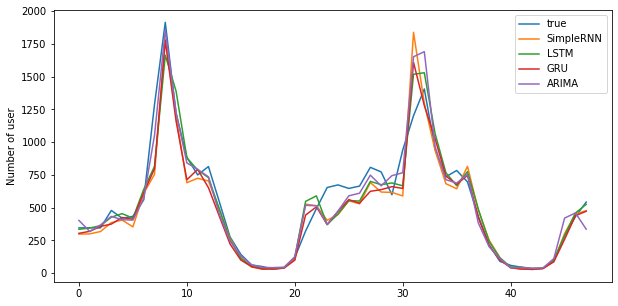

In [15]:
# 比較不同模型測試集合的預測值
figure(figsize=(10, 5))
plt.plot(np.exp(y_test.values)[0:48]-1,label = "true")
for tmp_model_str in ["SimpleRNN","LSTM","GRU","ARIMA"]:
    plt.plot(np.exp(test_predicts[tmp_model_str][0:48])-1,label=tmp_model_str)
    plt.ylabel("Number of user")
plt.legend(loc="upper right")

In [16]:
pd.DataFrame([test_RMSE,test_RMSE_org],index=["test_RMSE(log)","test_RMSE"]).T

test_RMSE(log)   test_RMSE
SimpleRNN        0.259060  117.222201
LSTM             0.266707  108.753793
GRU              0.240933  104.935180
ARIMA            0.272088  111.807303